In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
from rochev.hputil import *
from rochev.ldgdutil import lgcoeffs
from rochev import fvmodel_y as fvmodel
from rochev import get_ccfvel_itrnr as get_ccfvel
import dill

In [2]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax.config import config
import jax.numpy as jnp
from jax import random
config.update('jax_enable_x64', True)

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='sans-serif')
#sns.set_palette('colorblind')
plt.rcParams["figure.figsize"] = (18,6)
from matplotlib import rc
rc('text', usetex=False)

In [4]:
from astropy.constants import au, R_sun, M_sun, G
ar0 = (au/R_sun).value
vsini0 = (R_sun*2*np.pi/86400).value*1e-3
rho0 = (M_sun/R_sun**3/(4*np.pi/3)).value*1e-3
rho_crit = (3*np.pi/60**2/86400**2/G).value*1e-3
rho_crit0 = rho_crit/rho0

In [5]:
data = pd.read_csv("s12_rv.csv")
dlab = 'S12'
t = jnp.array(data.BJD)
y = jnp.array(data.rv)
yerr = jnp.array(data.rv_err)
t_epoch = t[0]
wavmin, wavmax = 388, 882 # wavelength coverage
idx = t!=2454073.62965 # outlier
print (t_epoch)

2454065.57926


In [6]:
t -= t_epoch
t, y, yerr = t[idx], y[idx], yerr[idx]

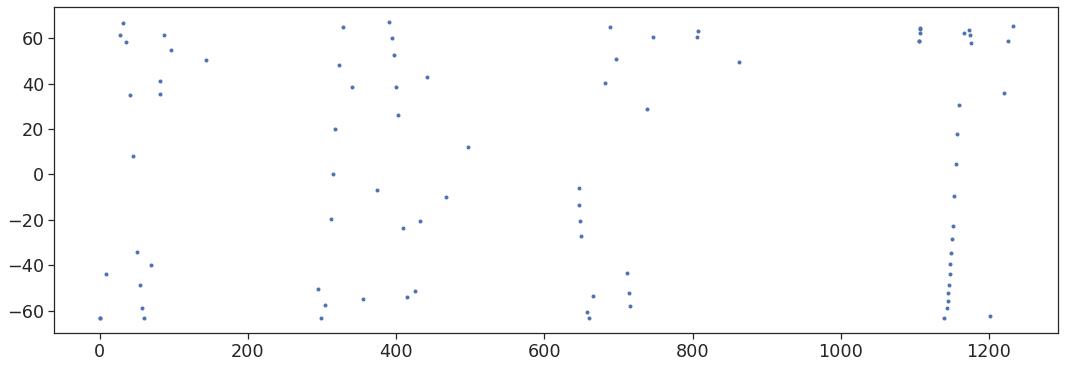

In [7]:
plt.plot(t, y, '.')

In [8]:
def physical_model(t, y, minfo):
    m1 = numpyro.sample("m1", dist.TruncatedNormal(loc=1., scale=0.5, low=0.5))
    r1 = numpyro.sample("r1", dist.TruncatedNormal(loc=24.0, scale=0.9, low=15.))
    lnq = numpyro.sample("lnq", dist.Uniform(low=0, high=2))
    q = jnp.exp(lnq)
    m2 = m1 * q
    cosi = numpyro.sample("cosi", dist.Uniform(low=0, high=1))
    inc = jnp.arccos(cosi)
    sini = jnp.sqrt(1.-cosi*cosi)
    fm = (m2*sini)**3 / (m1+m2)**2

    period = numpyro.sample("period", dist.Uniform(59.9, 60.0))
    #t0 = numpyro.sample("t0", dist.Uniform(19, 21)) # For G14
    t0 = numpyro.sample("t0", dist.Uniform(764.5, 765.5)) # For S12
    sma = (m1+m2)**(1./3.) * (period/365.25)**(2./3.) # AU
    a = ar0 * sma / r1

    _q = 1./q
    a_crit = (0.6*_q**(2./3.) + jnp.log(1+_q**(1./3.)))/(0.49*_q**(2./3.))
    numpyro.deterministic("acrit", a_crit)
    numpyro.factor("afactor", jnp.where(a > a_crit, 0, -jnp.inf))

    K = (fm/1.036e-7/period)**(1./3.)
    gamma = numpyro.sample("gamma", dist.Uniform(low=-10, high=10))
    lnjit = numpyro.sample("lnjit", dist.Uniform(low=-5, high=0))
    jit = jnp.exp(lnjit)

    vsini = vsini0 / period * sini * r1
    numpyro.deterministic("vsini", vsini)

    #weff = numpyro.sample("leff", dist.Uniform(wavmin, wavmax))
    #wc, wd = 0.5*(wavmin+wavmax), 0.25*(wavmax-wavmin)
    #numpyro.factor("logpleff", -0.5*(weff-wc)**2/wd**2)
    weff = 0.5 * (wavmin + wavmax) # fixed for testing

    _ygd, _u1, _u2 = lgcoeffs(weff)
    ygd = numpyro.sample("ygd", dist.Normal(loc=_ygd, scale=0.1))
    u1 = numpyro.sample("u1", dist.Normal(loc=_u1, scale=0.1))
    u2 = numpyro.sample("u2", dist.Normal(loc=_u2, scale=0.1))

    numpyro.deterministic("m2", m2)
    numpyro.deterministic("K", K)
    numpyro.deterministic("massfunc", fm)
    numpyro.deterministic("mratio", q)
    numpyro.deterministic("a", a)

    x = (t-t0)/period * 2 * jnp.pi
    phases = x + 0.5*jnp.pi
    rvbase = -K * jnp.sin(x)
    numpyro.deterministic("rvmodel_base0", rvbase)
    rvbase = rvbase + gamma

    vmac = numpyro.sample("vmac", dist.TruncatedNormal(loc=5.3, scale=1.0, low=1)) # FeH=-1
    dvsigma = numpyro.sample("dvsigma", dist.HalfNormal(scale=1.))
    vsigma = 2.95 + dvsigma
    numpyro.deterministic("vsigma", vsigma)

    Xf, V, cosg, _ = fvmodel(minfo, phases, inc, u1, u2, q, a, ygd)
    flux = jnp.sum(Xf, axis=1)
    vel_cent = vsini * jnp.sum(V*Xf, axis=1) / flux
    drv = get_ccfvel(vel_cent, Xf, V, cosg, vsini, vmac, vsigma)

    rvs = rvbase + drv
    numpyro.deterministic("rvmodel", rvs)
    numpyro.deterministic("rvmodel_base", rvbase)
    numpyro.deterministic("rvmodel_anom", drv)
    numpyro.deterministic("fluxmodel", flux)
    res = y - rvs

    sigma2 = yerr**2 + jit**2
    lnsigma2 = jnp.log(sigma2)
    loglikelihood = -0.5 * jnp.sum(res**2/sigma2 + lnsigma2)
    numpyro.factor("loglike", loglikelihood)

In [21]:
#%% choose resolution of healpix map
nside = 8 #should be >=8
minfo = hpmap_info(create_hpmap(nside))

approximate resolution: 7.33deg


In [22]:
kernel = numpyro.infer.NUTS(physical_model, target_accept_prob=0.9)
basename = "s12rv_n%d"%nside

In [23]:
n_sample = 100 # short run for testing

In [24]:
basename += '_s%d'%n_sample
print (basename)

s12rv_n8_s100


In [25]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=n_sample, num_samples=n_sample)

In [26]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, t, y, minfo, extra_fields=('potential_energy',))

sample: 100%|█████████████| 200/200 [21:12<00:00,  6.36s/it, 255 steps of size 3.36e-03. acc. prob=0.95]


In [27]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      cosi      0.15      0.10      0.12      0.01      0.26     22.16      0.99
   dvsigma      1.00      0.64      0.86      0.11      1.97     26.31      1.00
     gamma      1.89      0.03      1.89      1.83      1.93     91.02      0.99
     lnjit     -1.81      0.21     -1.79     -2.15     -1.49     86.87      1.00
       lnq      1.29      0.13      1.27      1.08      1.47     23.25      1.01
        m1      0.82      0.11      0.82      0.62      0.96     32.68      0.99
    period     59.94      0.00     59.94     59.94     59.94     88.69      0.99
        r1     24.18      0.79     24.25     22.53     25.26     57.53      0.99
        t0    764.97      0.01    764.97    764.96    764.98     96.34      0.99
        u1      0.64      0.09      0.64      0.51      0.79     84.63      0.99
        u2      0.19      0.11      0.18      0.02      0.37     87.11      0.99
      vmac      5.52      0

In [28]:
samples = mcmc.get_samples()

In [29]:
keys = ["m1", "r1", "mratio", "t0", "period", "cosi", "vsigma", "vmac", "gamma", "lnjit"]
labels = keys

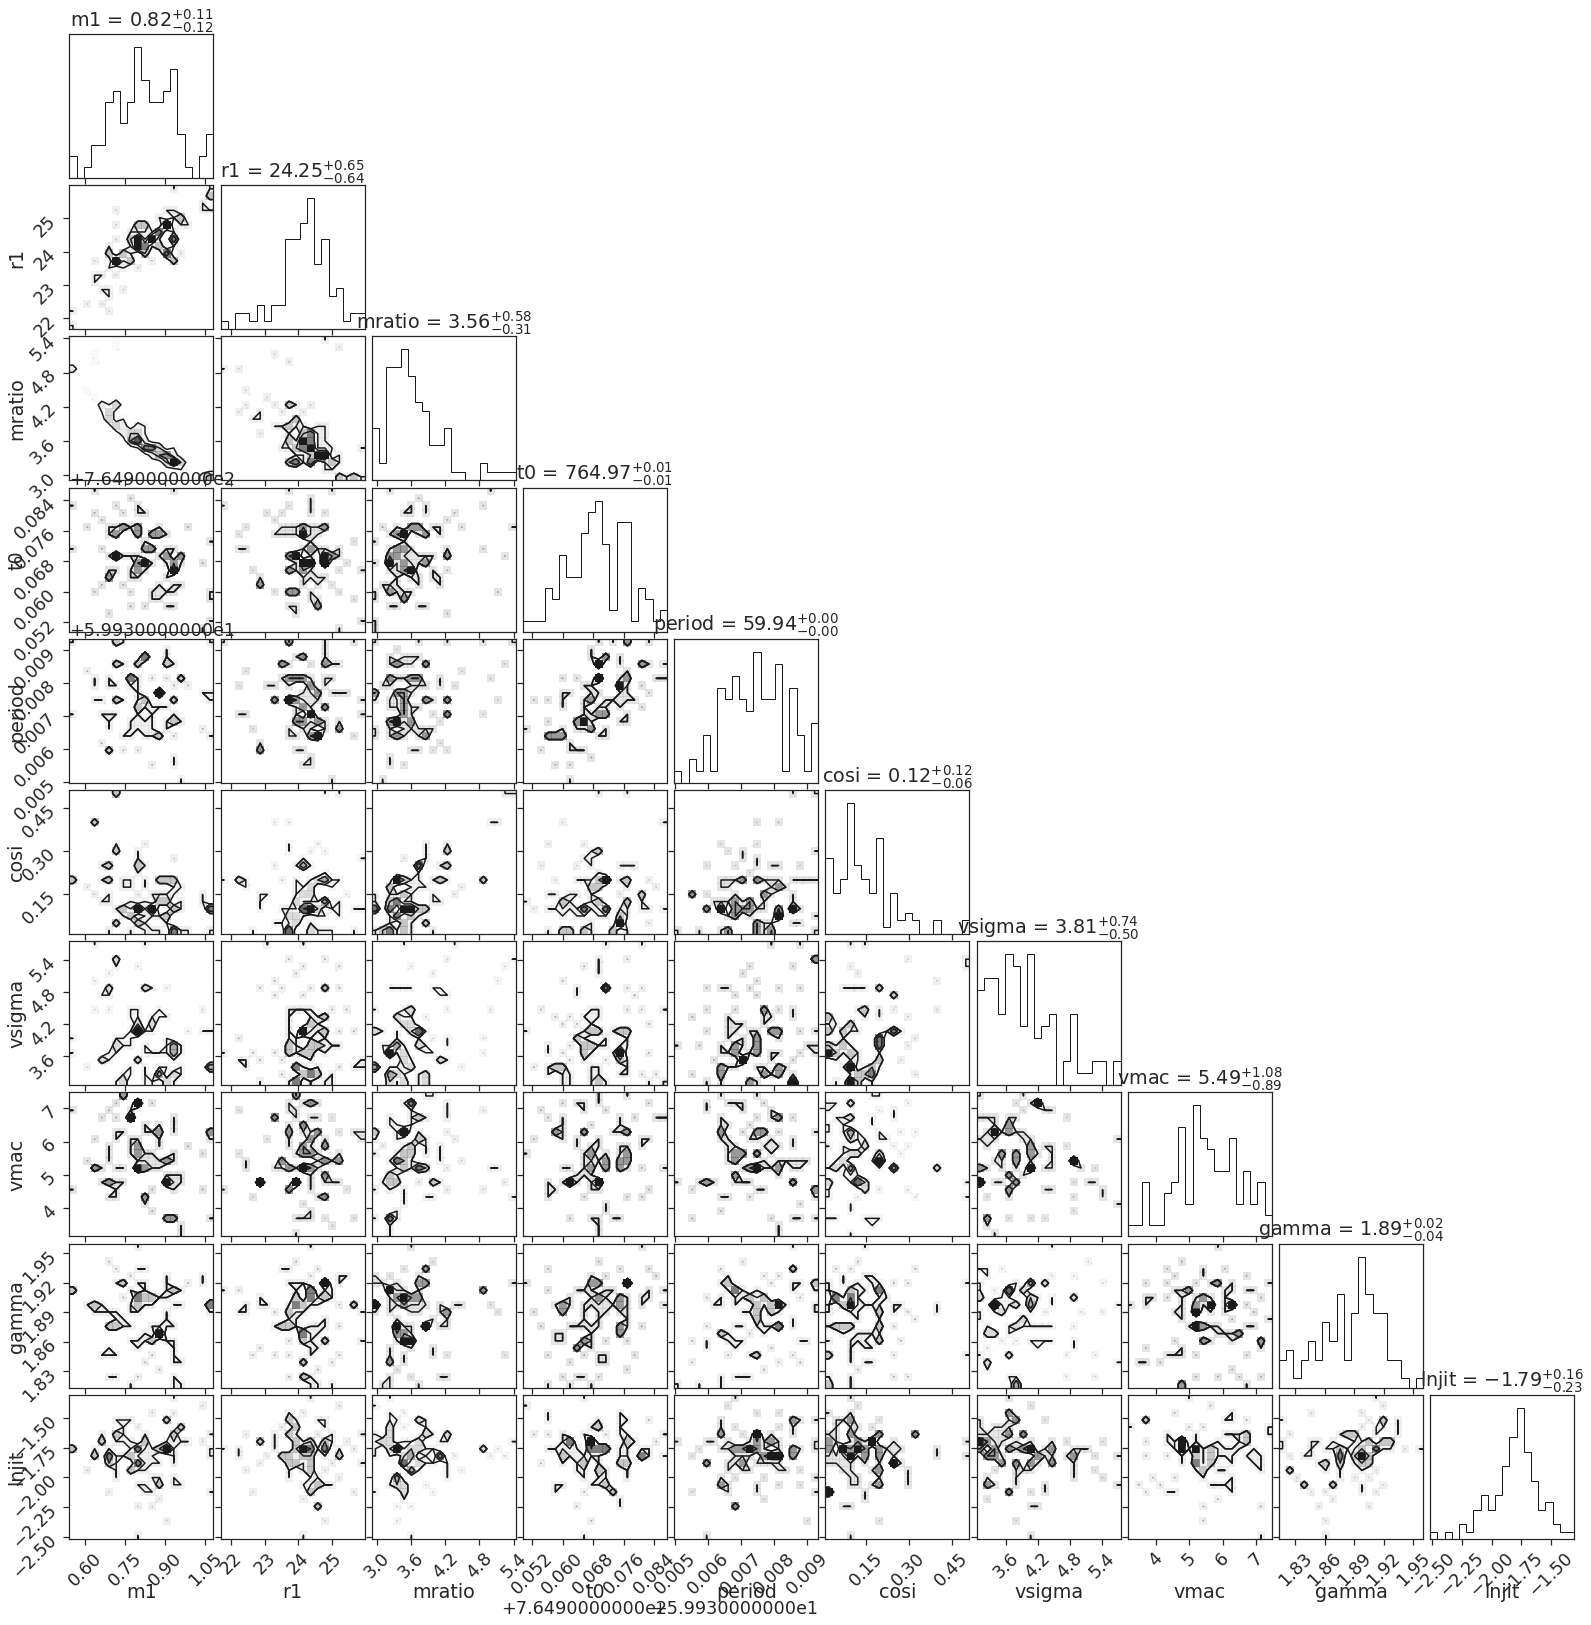

In [36]:
hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
fig = corner.corner(hyper, labels=labels, show_titles="%.2f")

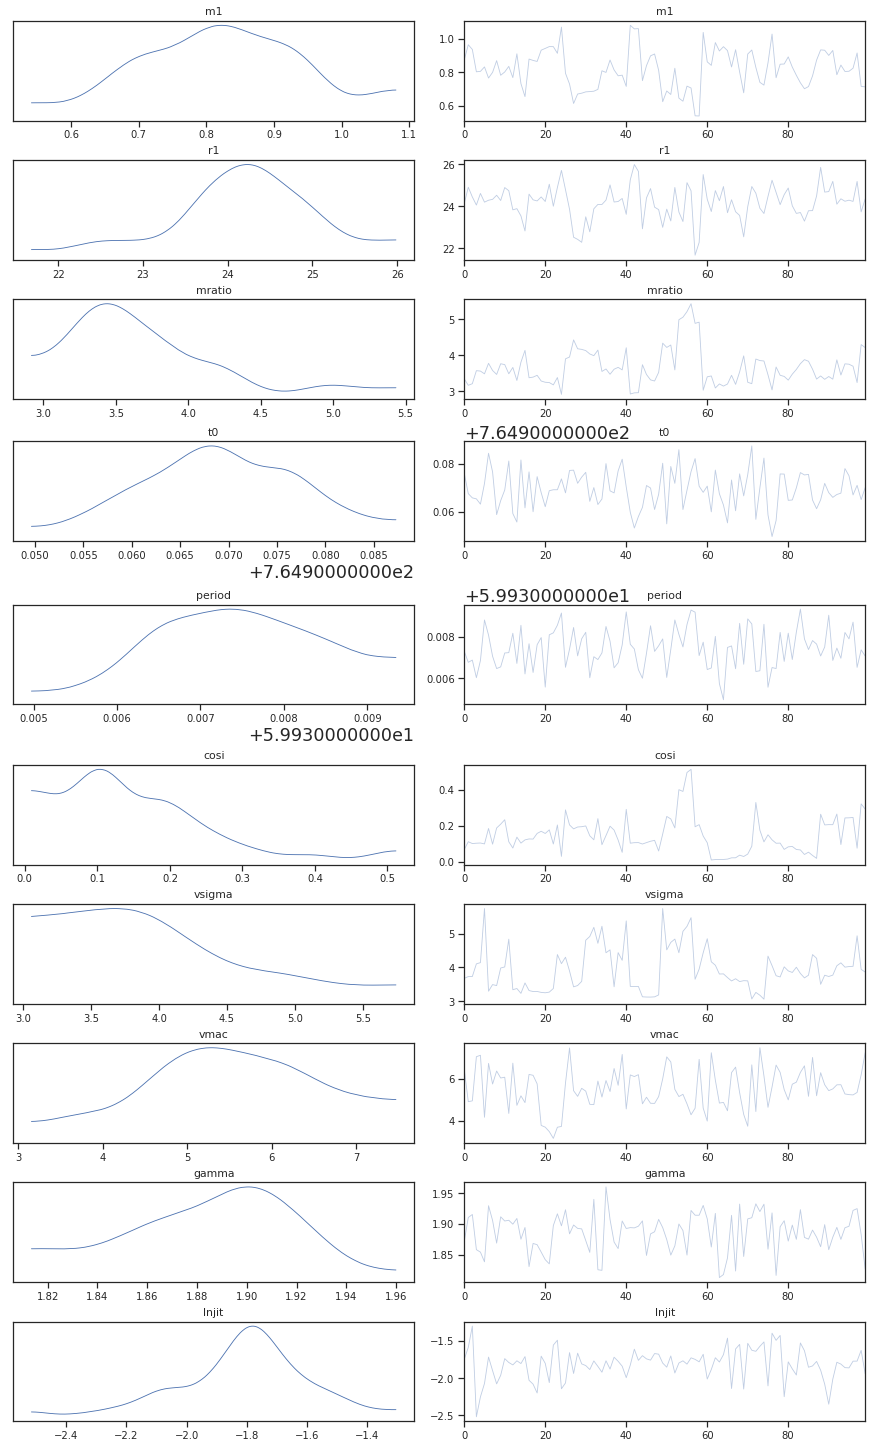

In [38]:
import arviz
fig = arviz.plot_trace(mcmc, var_names=keys)

In [39]:
rvmodels = np.array(mcmc.get_samples()["rvmodel"])
rvmodel_mean = np.mean(rvmodels, axis=0)
rvmodel_std = np.std(rvmodels, axis=0)

brvs = np.array(mcmc.get_samples()["rvmodel_base"])
brv_mean = np.mean(brvs, axis=0)
brv_std = np.std(brvs, axis=0)

brvs0 = np.array(mcmc.get_samples()["rvmodel_base0"])
brv0_mean = np.mean(brvs0, axis=0)
brv0_std = np.std(brvs0, axis=0)

drvs = np.array(mcmc.get_samples()["rvmodel_anom"])
drv_mean = np.mean(drvs, axis=0)
drv_std = np.std(drvs, axis=0)

fluxes = np.array(mcmc.get_samples()["fluxmodel"])
flux_mean = np.mean(fluxes, axis=0)
flux_std = np.std(fluxes, axis=0)

pbest = np.mean(mcmc.get_samples()["period"])
t0best = np.mean(mcmc.get_samples()["t0"])
x_phase = (t - t0best  + 0.5 * pbest) % pbest - 0.5 * pbest
idx = np.argsort(x_phase)

/home/km/anaconda3/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4615: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


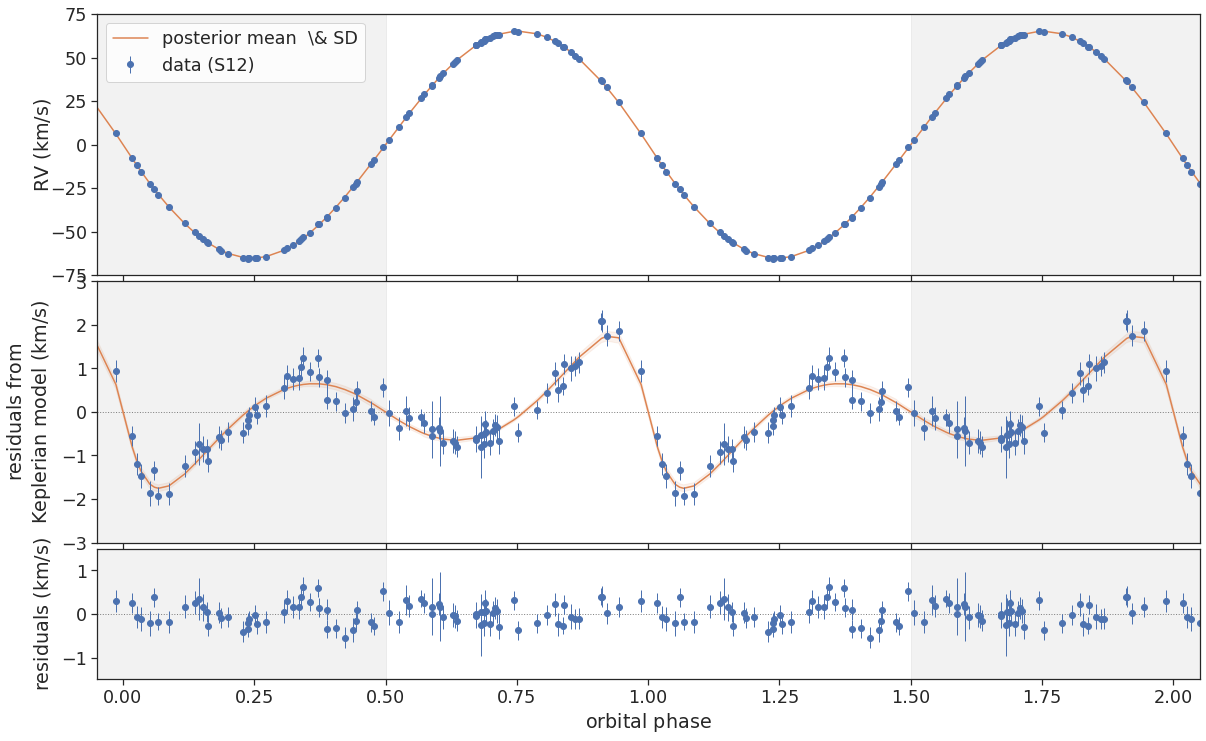

In [40]:
jitbest = np.exp(np.mean(mcmc.get_samples()["lnjit"]))
jitbest = jnp.sqrt(jitbest**2 + yerr**2)
gamma = np.mean(mcmc.get_samples()["gamma"])
x = x_phase[idx]/pbest
_x = np.r_[x, x+1, x+2]
fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2, 2, 1]}, figsize=(33*0.5,(18+2)*0.5), sharex=True)
plt.xlim(-0.05, 2.05)
ax[-1].set_xlabel("$\mathrm{orbital\ phase}$")
ax[0].set_ylabel("$\mathrm{RV\ (km/s)}$")
ax[0].set_ylim(-75, 75)
ybase = 0.
#_y = (rvmodel_mean-ybase)[idx]
_y = (brv0_mean+drv_mean-ybase)[idx]
ax[0].plot(_x, np.tile(_y, 3), color="C1", label=u"posterior mean  \& SD")
_x1 = x
_y1 = (y-ybase)[idx]
ax[0].errorbar(np.r_[_x1, _x1+1, _x1+2], np.tile(_y1, 3)-gamma, yerr=np.tile(jitbest, 3), fmt='o', label='data (%s)'%dlab, lw=1)
ax[1].set_ylabel("$\mathrm{residuals\ from}$\n$\mathrm{Keplerian\ model\ (km/s)}$")
ax[1].set_ylim(-3, 3)
ybase = brv_mean
_y = (rvmodel_mean-ybase)[idx]
ax[1].plot(_x, np.tile(_y, 3), color="C1", label=u"posterior mean")
_x1 = x
_y1 = (y-ybase)[idx]
ax[1].errorbar(np.r_[_x1, _x1+1, _x1+2], np.tile(_y1, 3), yerr=np.tile(jitbest, 3), fmt='o', label='data (%s)'%dlab, lw=1)
_yl, _yu = (rvmodel_mean-rvmodel_std-ybase)[idx], (rvmodel_mean+rvmodel_std-ybase)[idx]
ax[1].fill_between(_x, np.tile(_yl, 3), np.tile(_yu, 3), color="C1", alpha=0.1)
ax[1].axhline(y=0, color='gray', lw=1, zorder=-1000, ls='dotted')
ax[2].set_ylabel("$\mathrm{residuals\ (km/s)}$")
ax[2].set_ylim(-3*0.5, 3*0.5)
ybase = rvmodel_mean
_y = (rvmodel_mean-ybase)[idx]
#ax[1].plot(_x, np.tile(_y, 3), color="C1", label=u"posterior mean")
_x1 = x
_y1 = (y-ybase)[idx]
ax[2].errorbar(np.r_[_x1, _x1+1, _x1+2], np.tile(_y1, 3), yerr=np.tile(jitbest, 3), fmt='o', label='data (%s)'%dlab, lw=1)
_yl, _yu = (rvmodel_mean-rvmodel_std-ybase)[idx], (rvmodel_mean+rvmodel_std-ybase)[idx]
#ax[1].fill_between(_x, np.tile(_yl, 3), np.tile(_yu, 3), color="C1", alpha=0.1)
ax[2].axhline(y=0, color='gray', lw=1, zorder=-1000, ls='dotted')
#plt.axhline(y=1, color='gray', lw=1, zorder=-1000, ls='dotted')
ax[0].legend(loc="best")
fig.tight_layout(pad=0.005)
_y = np.linspace(-100, 100, 100)
ax[0].fill_betweenx(_y, -0.05, 0.5, color='gray', alpha=0.1)
ax[0].fill_betweenx(_y, 1.5, 2.05, color='gray', alpha=0.1)
ax[1].fill_betweenx(_y, -0.05, 0.5, color='gray', alpha=0.1)
ax[1].fill_betweenx(_y, 1.5, 2.05, color='gray', alpha=0.1)
ax[2].fill_betweenx(_y, -0.05, 0.5, color='gray', alpha=0.1)
ax[2].fill_betweenx(_y, 1.5, 2.05, color='gray', alpha=0.1)
ax[0].yaxis.set_label_coords(-0.04, 0.5)
ax[1].yaxis.set_label_coords(-0.04, 0.5)
ax[2].yaxis.set_label_coords(-0.04, 0.5)
#plt.savefig(basename+"_models.png", dpi=200, bbox_inches="tight")